# MACHINE LEARNING I
# 
# LAB ASSIGNMENT II: TIME SERIES

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the UnemploymentSpain.dat dataset and extract conclusions, performing several time series methods properly explained.

---

In [228]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st

---
## 1. Read the dataset

In [229]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285
...,...
2023-06-01,2688842
2023-07-01,2677874
2023-08-01,2702700


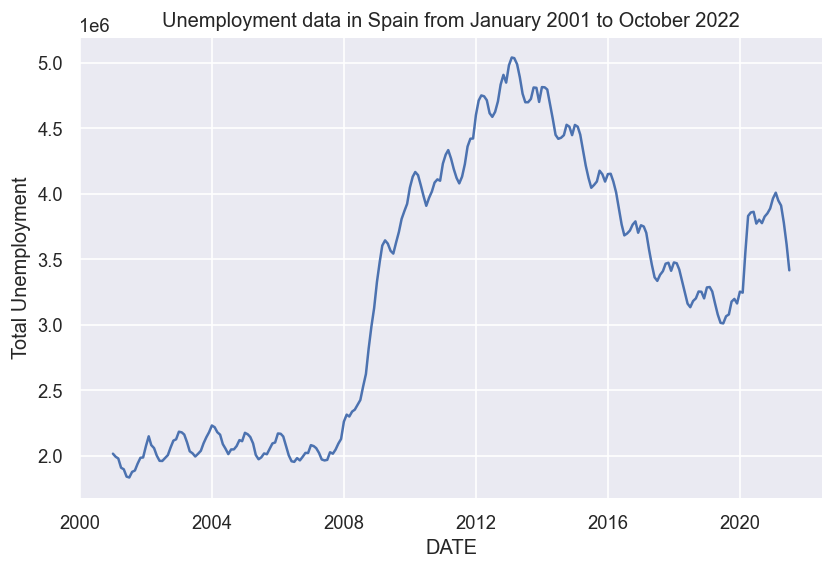

In [230]:
# Plotting a time series
fig, ax = plt.subplots()

datos_filtrados = df[df.index < '2021-08-01']
ax.plot('TOTAL', data=datos_filtrados)
ax.set(title='Unemployment data in Spain from January 2001 to October 2022', xlabel='DATE', ylabel='Total Unemployment')


plt.show()

In [231]:
y = df

prop_train=0.9



## Divide the data into training and test sets SEQUENTIALY -------------------------------------
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

y_train2 = y.iloc[0:round(prop_train*y.shape[0])] #Si funciona mal, cambiar por 0.9
y_test2 = y.iloc[round(prop_train*y.shape[0])+1:round(y.shape[0])]

y_train.head()

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285


Se divide el dataset en dos subconjuntos de entrenaimento y test. Esto es debido a que el último 20% corresponde al COVID, y si se utilizase un 80/20 sería el conjunto de test el del COVID, dando una sensación falsa de que el modelo es malo, y sin poder captar el verdadero comportamiento de la pandemia. Por ello, si se quieren entrenar modelos, se usan primero los datos sin COVID con una proporción aproximada de 80/20 (en el total, una relación 64/16). Con ello, se pretende conseguir un modelo que ajuste bien la serie temporal sin comportamientos anómalos y con menos riesgo de sobreajuste que si únicamente se utilizase entrenamiento, ya que se puede comprobar su comportamiento en el test.

Tras eso, se estudia de nuevo la serie en una proporción 88/12 (para que el test no sea prácticamente del COVID, pero haya algún comportamiento raro en el test para observar diferencias entre modelos) y, basándonos en un modelo que sabemos que no tiene un gran sobreajuste y es decente en predicciones y métricas, se realizan los reajustes necesarios para estos nuevos datos, con la intención de que sea un modelo decente en sus predicciones y sin que peque de sobreajuste.

---
### Identification process

Se comienza trabajando únicamente con el subconjunto de entrenamiento.

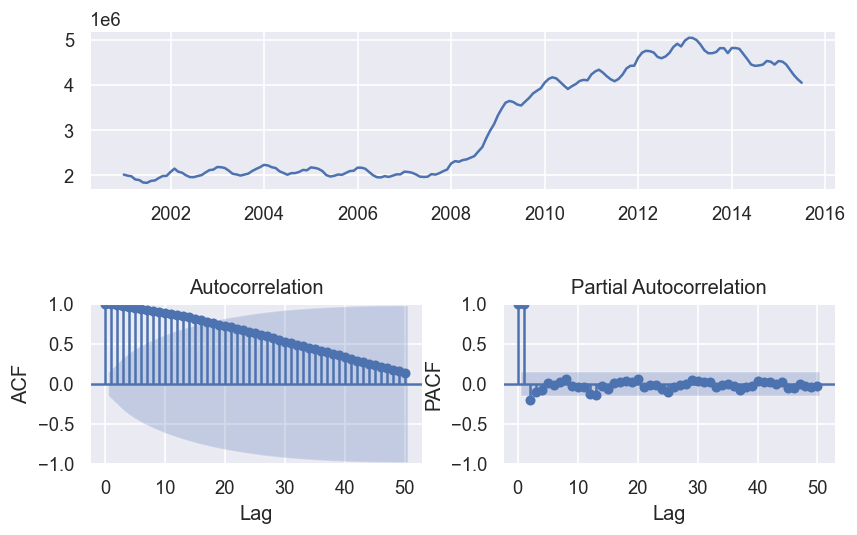

In [232]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train,lags=50)

#### 2. Stabilize the variance (if needed)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

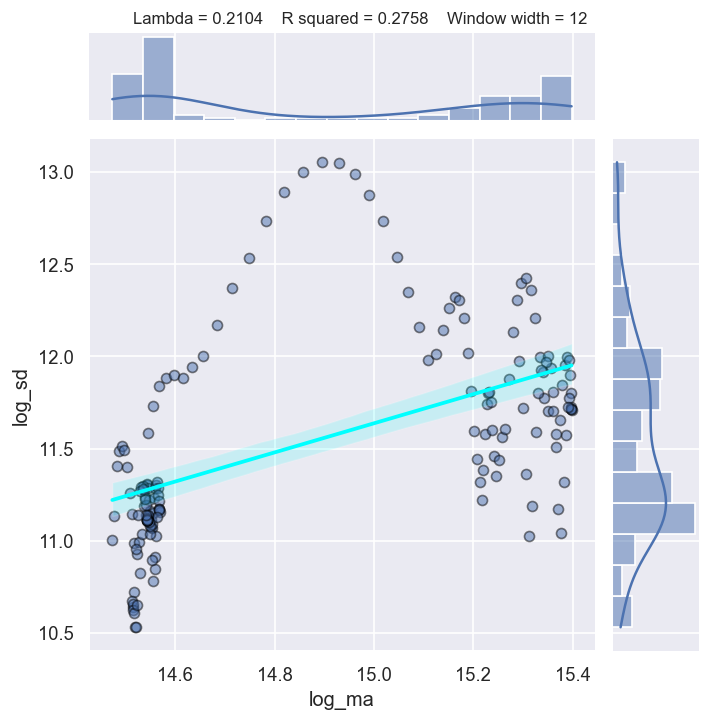

In [233]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train, window_width=12)

En este caso se aprecia una relación entre ambas, pero una no lineal. Por ello, ambas opciones podrían ser correctas, pero decidimos aplicar Box-Cox ya que creemos que puede ayudar ligeramente, y en los modelos no se observan cambios muy relevantes.

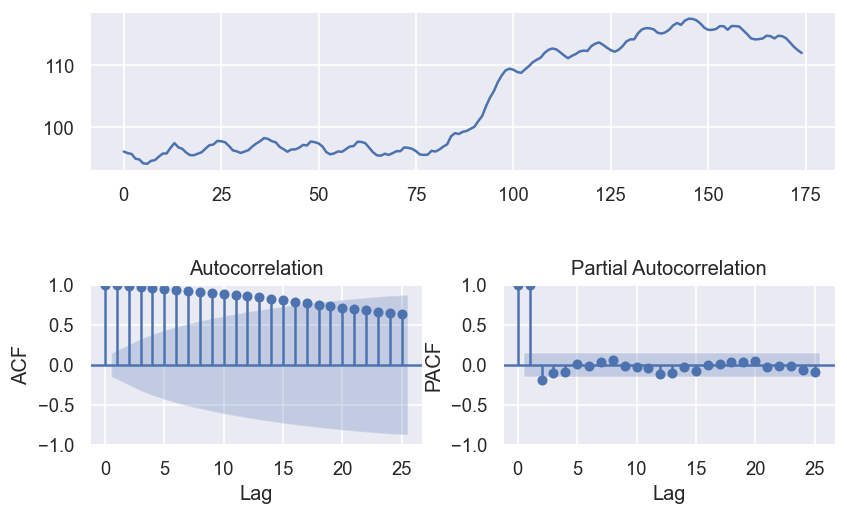

In [234]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train

# Plot transformed data
FT.ts_display(z)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

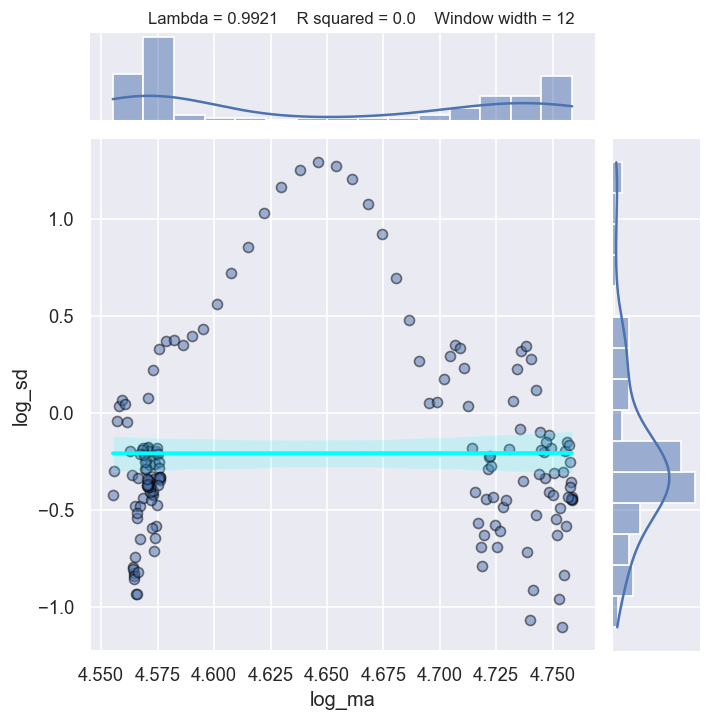

0.9921306069971021

In [235]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

In [236]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.391117
p-value: 0.586527
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


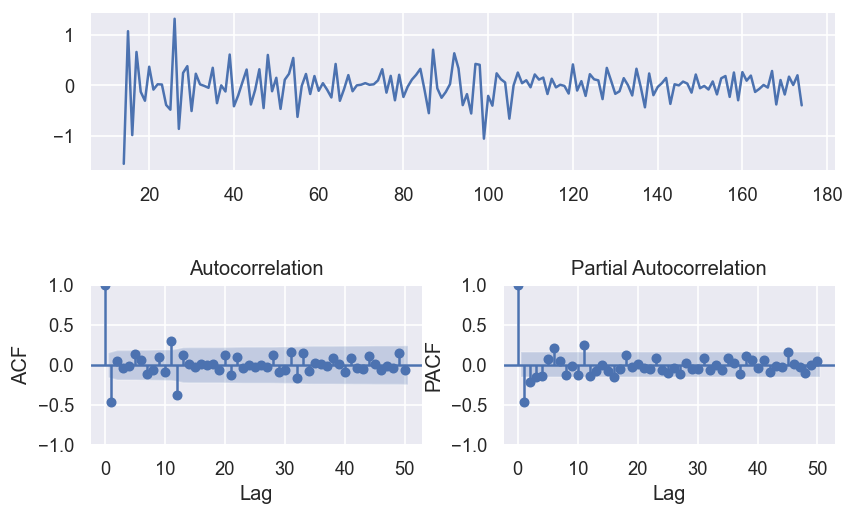

In [237]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Se podría plantear usar solo una diferenciación y aplicar modelos ARMA (se ha comprobado que esto último da ligeramente mejores resultados en entrenamiento, pero peores en test en la predicción y principales métricas).

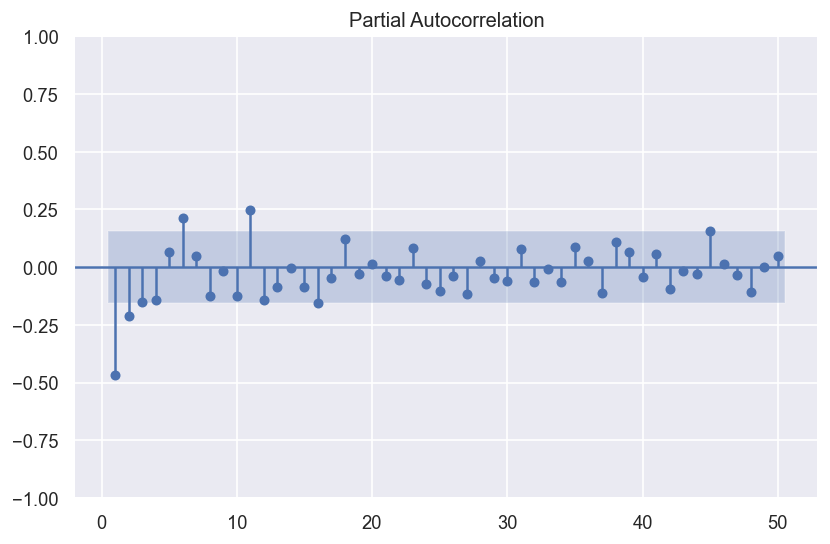

<Figure size 960x600 with 0 Axes>

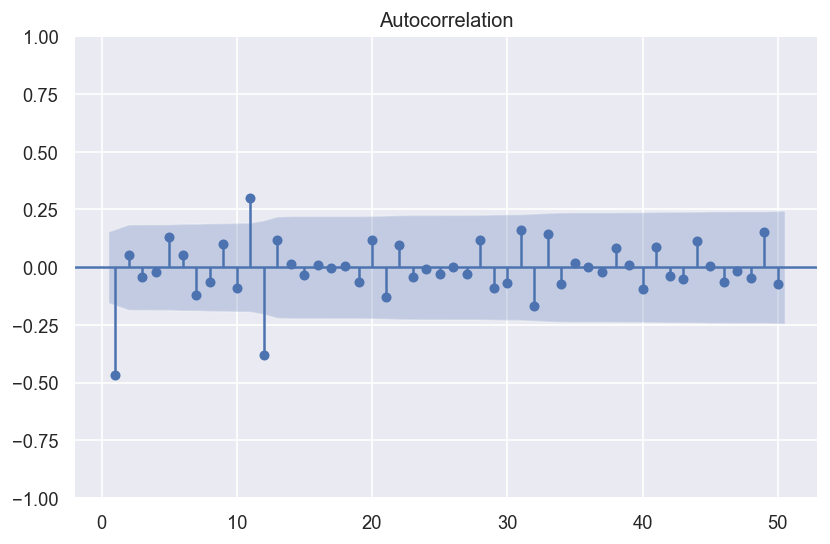

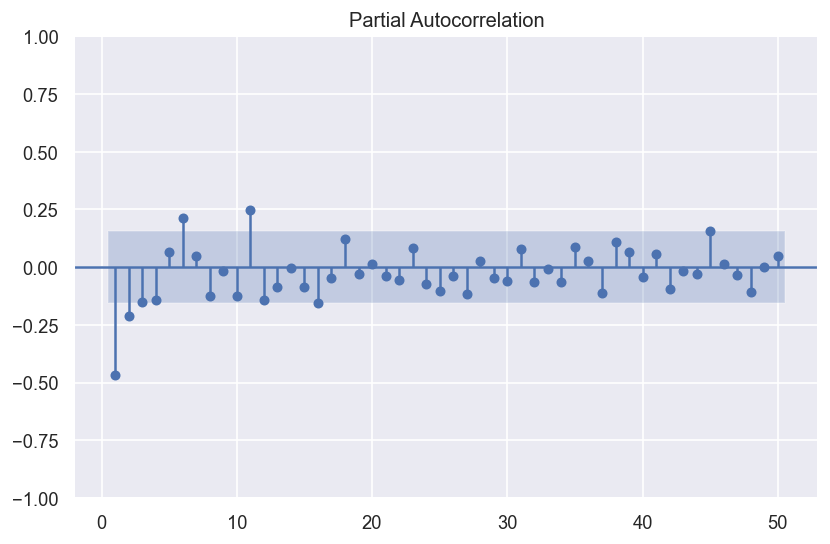

In [238]:
#Bigger plots
plt.figure()
plot_acf(Bz, lags=50,zero=False)
plot_pacf(Bz, lags=50,zero=False)

It seems necessary a moving average model (0,2,1) or an ARMA (1,1,1) for the regular terms, and a mix in the seasonal terms, or a moving average (0,1,1).

#### 5. Fit ARIMA model and check significance of the coefficients

In [239]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(0,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  175
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                  -3.797
Date:                            Tue, 28 Nov 2023   AIC                             13.594
Time:                                    19:48:22   BIC                             22.838
Sample:                                         0   HQIC                            17.347
                                            - 175                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6389      0.049    -12.985      0.000      -0.735      -0.542
ma.S.L12      -0.6935      0.080   

#### 6. Analyze residuals

Se comienzan los residuos en 20 al ser 262 datos, puesto que si se empieza desde 100 sería casi la mitad del conjunto de datos de los que no se estudian los residuos.

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  31.812202   0.163518


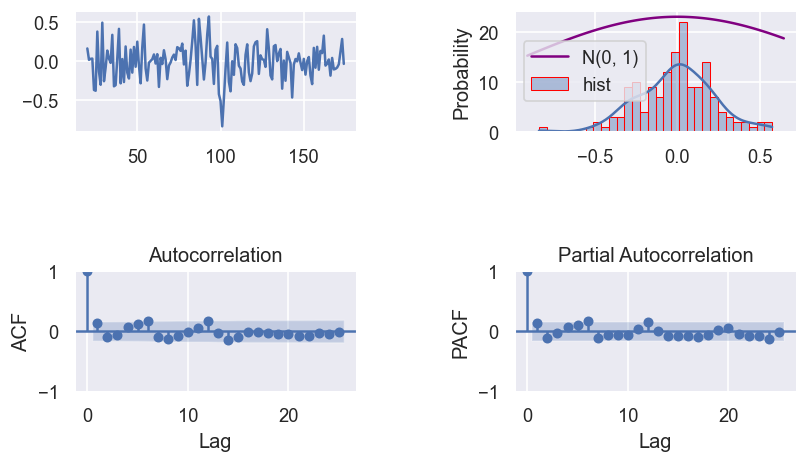

In [240]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

Este modelo es válido, siendo el mejor en términos de AIC, BIC, relación entre el número de coeficientes y precisión, etc. No obstante, se puede crear otro modelo incluyendo variables no significativas a costa de unos mejores resultados de residuos, debido a que el sexto residuo parece algo significativo en el anterior gráfico (Puede ser debido a que no se capte de forma perfecta el efecto estacional).

In [241]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(6,2,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  175
Model:             SARIMAX(6, 2, 0)x(0, 1, [1], 12)   Log Likelihood                   0.725
Date:                              Tue, 28 Nov 2023   AIC                             14.550
Time:                                      19:48:28   BIC                             39.201
Sample:                                           0   HQIC                            24.559
                                              - 175                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6497      0.061    -10.594      0.000      -0.770      -0.529
ar.L2         -0.39

#### 6. Analyze residuals

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.324358   0.828315


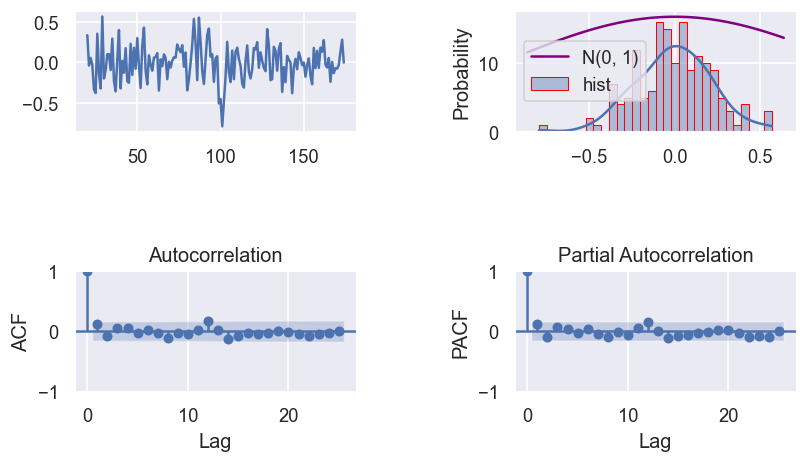

In [242]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

Es mejor en términos de error, pero a grandes rasgos parece más correcto el primero. Observamos a continuación su desempeño en test.

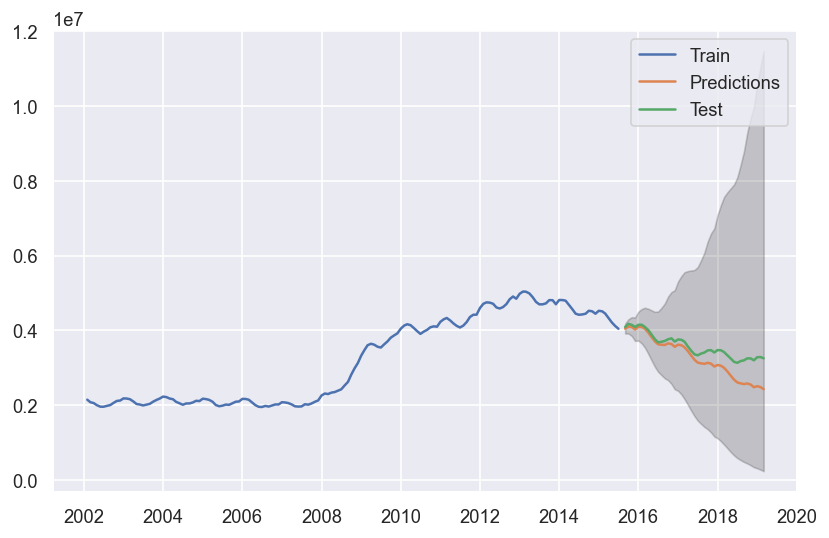

In [243]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

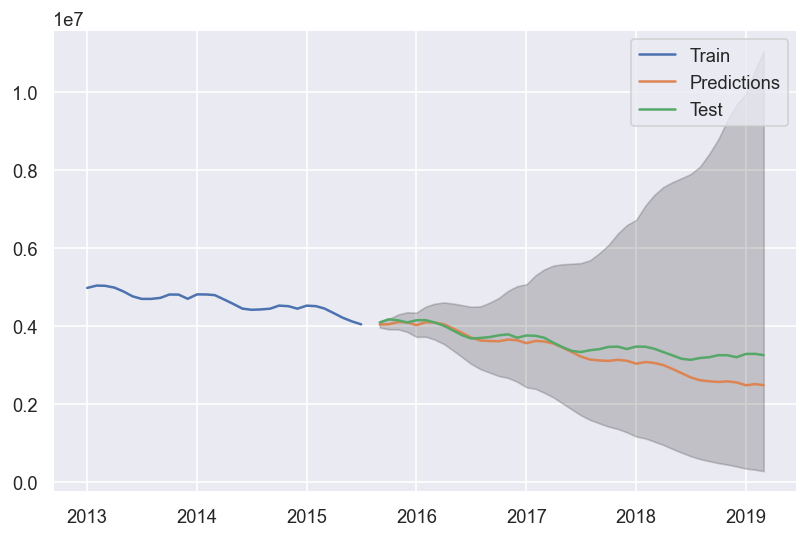

In [244]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0]) + 1
end = round(0.8*y.shape[0])
horizon = end - start

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2013-01-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

Resultados de BIC y AIC para los modelos en test:

In [245]:
pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 2: 266691.875229543
Test RMSE SARIMA 1 d = 2: 360943.5404256374


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [246]:
# Fit model with estimated order
sarima_fit_aux = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

pred = sarima_fit_aux.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 1: 210235.35596807319
Test RMSE SARIMA 1 d = 1: 240100.19945847962


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [109]:
pred = sarima_fit2.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 2: 234971.0232838794
Test RMSE SARIMA 2: 320144.3241232632


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

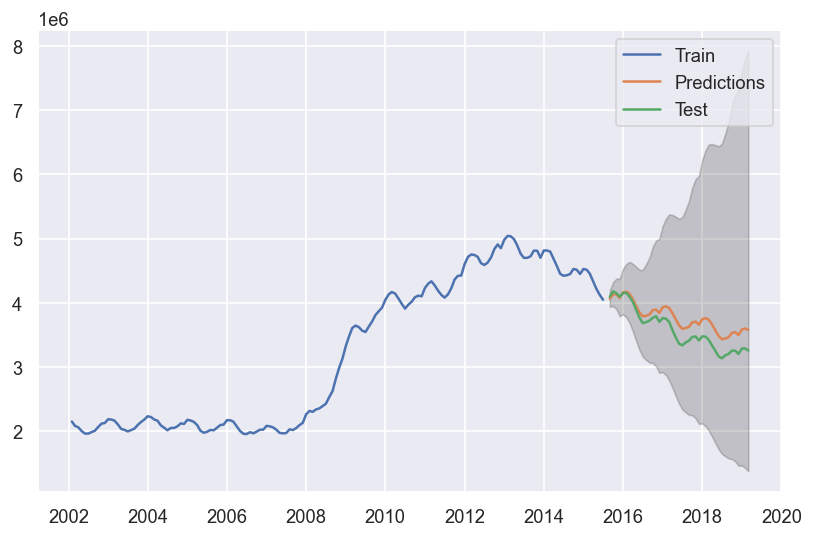

In [110]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit_aux.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

A pesar de lo esperado, el mejor modelo es `sarima_fit_aux` en términos de métricas y simplicidad (con unas predicciones similares), por lo que se usará este modelo a continuación en el conjunto de entrenamiento con prácticamente la totalidad de los datos para reajustar los parámetros sabiendo que es el mejor posible, aplicando los mismos pasos que anteriormente y observando los resultados finales.

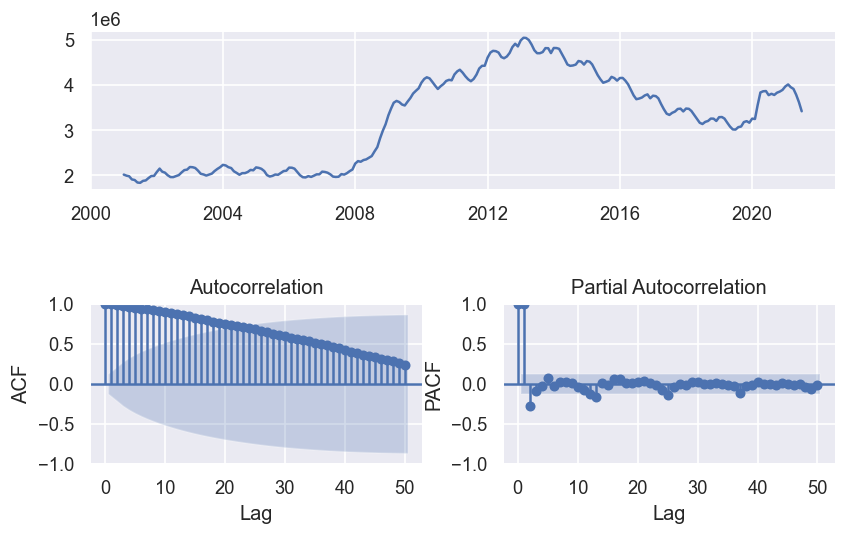

In [247]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train2,lags=50)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

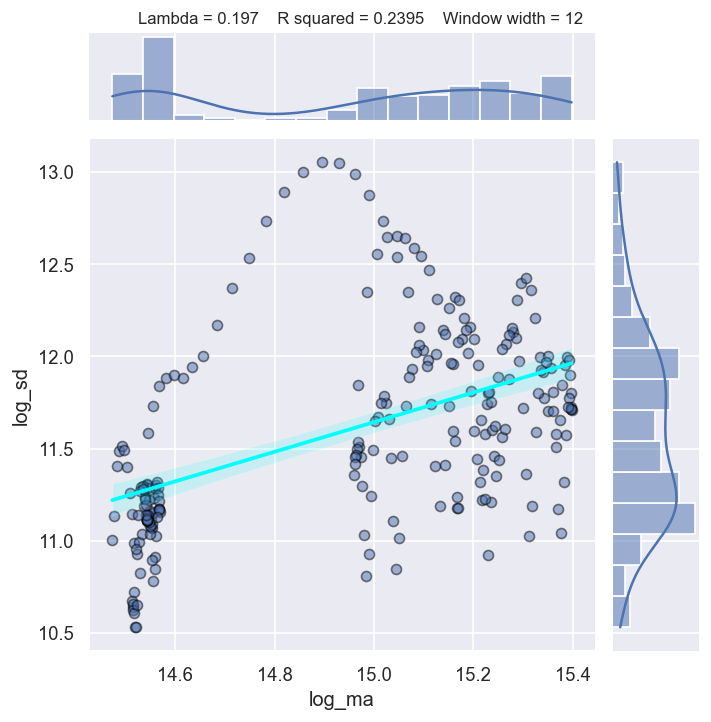

In [248]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

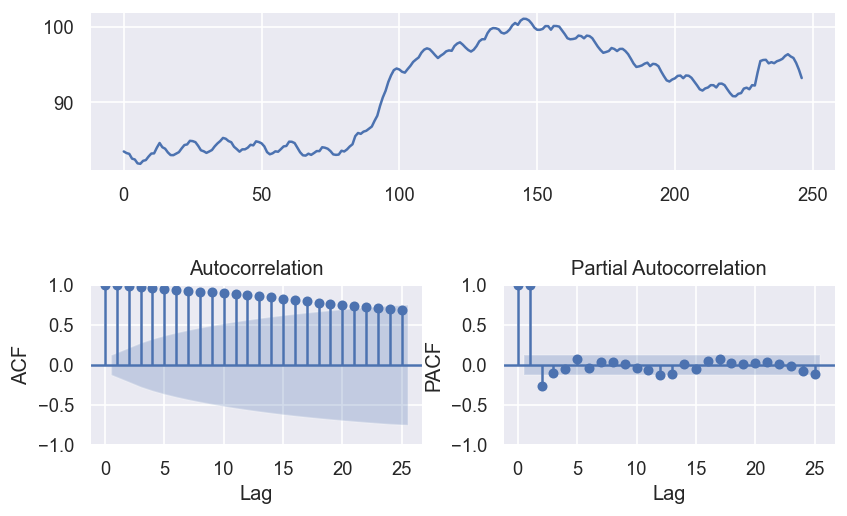

In [249]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train2.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
FT.ts_display(z)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

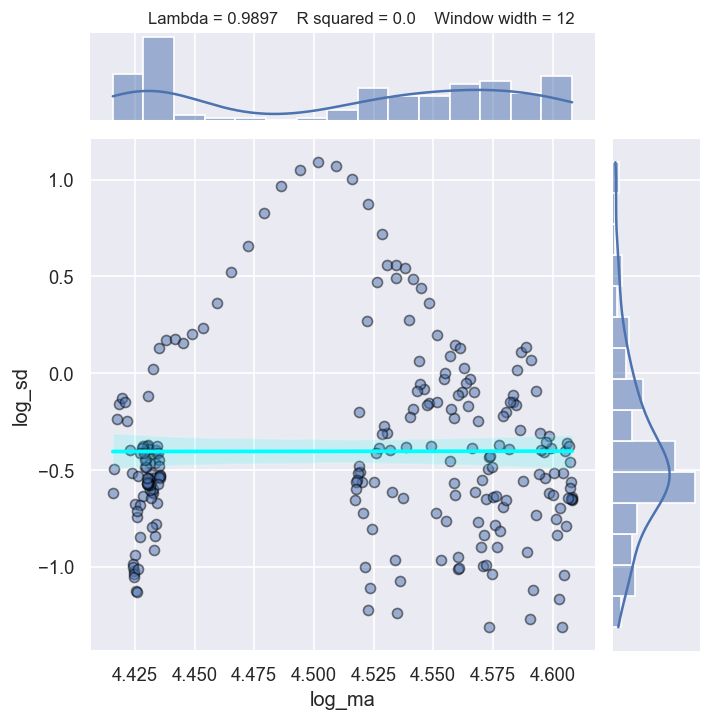

0.9897159598538307

In [250]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

In [251]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.575549
p-value: 0.495863
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


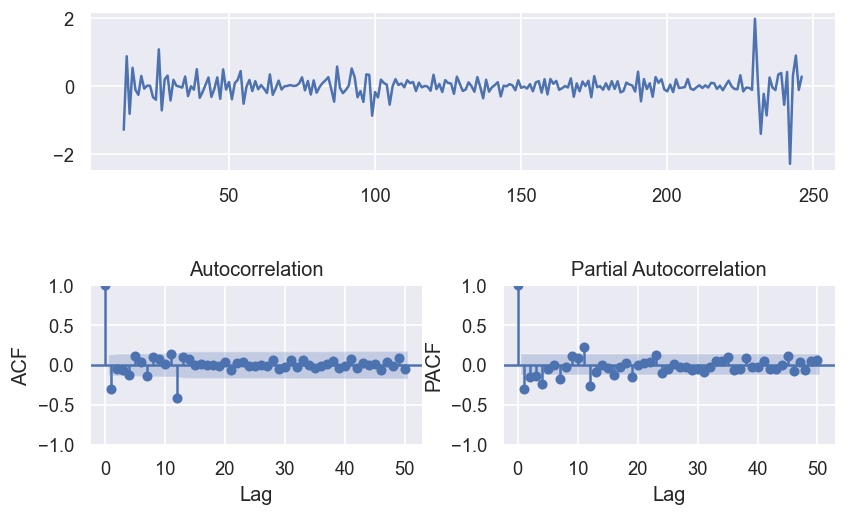

In [252]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Parece que nos lleva a resultados similares, aunque al final de la serie se observa un cambio muy grande en la serie debido a lo anteriormente comentado: el COVID.

In [253]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  247
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                 -10.723
Date:                            Tue, 28 Nov 2023   AIC                             29.447
Time:                                    19:49:05   BIC                             43.251
Sample:                                         0   HQIC                            35.013
                                            - 247                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4341      0.058      7.491      0.000       0.320       0.548
ma.L1         -0.8568      0.044   

Observamos que en este caso admite también un término autorregresivo, siendo éste un pequeño reajuste como los que hablábamos.

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  17.210533   0.874016


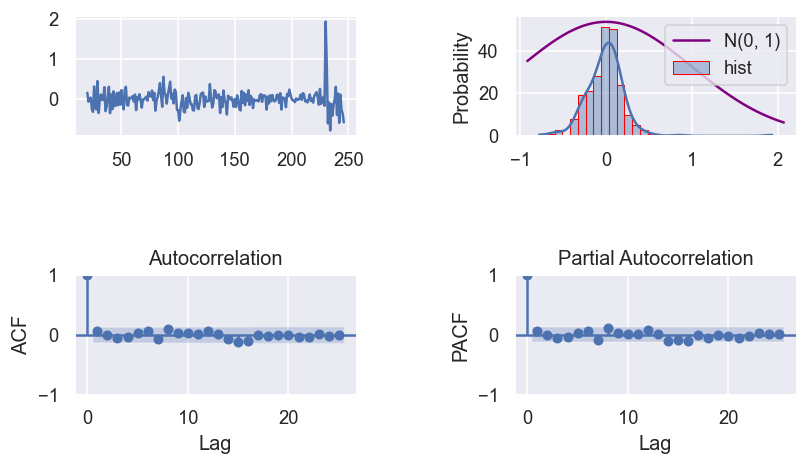

In [254]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

El error es bastante bueno, se observan a continuación diversas métricas y la predicción.

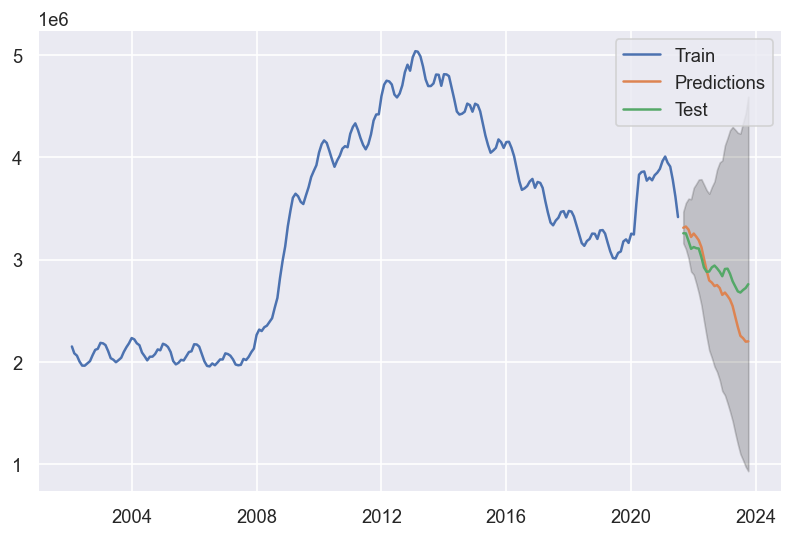

In [255]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

Como se puede observar, la predicción es bastante mala, no captando en absoluto la bajada. Por tanto, se pueden probar otros modelos como el inicial (0,2,1) o el otro posible comentado al comienzo con una diferenciación (1,1,1). El primero mejora algo los errores, pero sigue sin captar la tendencia. El segundo, sin embargo, además de ser más sencillo, sus resultados son mejores, pero tiene una explicación.

In [256]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 208747.3711684086
Test RMSE SARIMA 1 d = 2: 254817.38219286932


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [257]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  247
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  -8.421
Date:                            Tue, 28 Nov 2023   AIC                             24.843
Time:                                    19:49:29   BIC                             38.664
Sample:                                         0   HQIC                            30.416
                                            - 247                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7570      0.054     14.072      0.000       0.652       0.862
ma.L1         -0.2129      0.066   

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.017474   0.841648


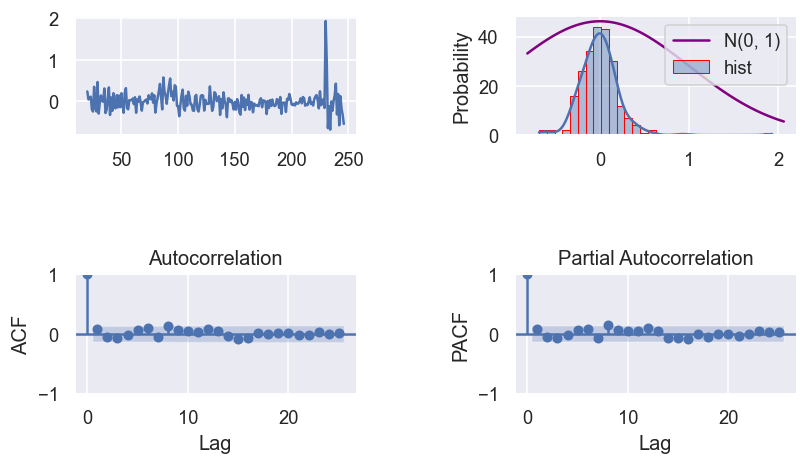

In [258]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

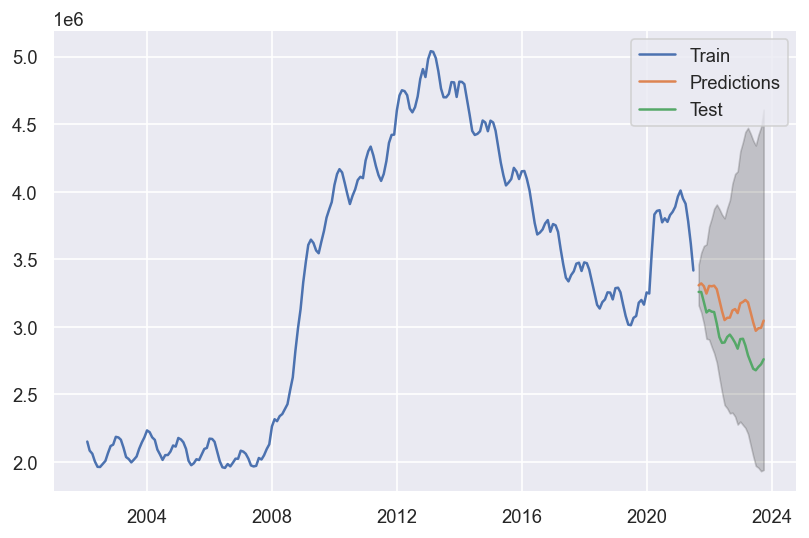

In [261]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit2.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [260]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test2, yhat)))

ValueError: Found input variables with inconsistent numbers of samples: [26, 32]

Como se puede observar, este modelo menos complejo simplemente sigue con mayor exactitud los últimos datos reales, por lo que su menor error es pura coincidencia, fruto de la bajada repentina, pero no quiere decir que en general sea un mejor modelo o sobreajuste menos que los anteriores. De hecho, parecen modelos más precisos los previos, pero claramente ninguno es capaz de capturar esa gran bajada, como es lógico.

No obstante, los residuos son claramente independientes en todos los casos, y no se observa ningún retardo significativo. No obstante, se puede ver un gran outlier que, junto con lo comentado anteriormente, nos indica de la gran necesidad de añadir algún tipo de tendencia o parámetro para modelar los efectos del COVID como, por ejemplo, una variable de intervención. Por tanto, ése será el siguiente paso.

# **SARIMAX**

Se procede a incluir una variable de intervención que palie el efecto provocado por el COVID en nuestra serie temporal.

Esta variable simplemente será una binaria que tome el valor 1 para observaciones en fechas dentro del periodo en que el COVID tuvo un efecto en la serie, y 0 para las fechas fuera de dicho periodo.

In [262]:
df['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-01-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2=pd.to_datetime('2021-10-01')
# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19

df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] = 1
df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID'] = -1


df['COVID'].describe()#únicamente el COVID afecta a un 11% de nuestras observaciones

count    274.000000
mean       0.000000
std        0.270666
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: COVID, dtype: float64

In [264]:
INPUTS_SARMAX = 'COVID'
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]



In [265]:
X = pd.DataFrame(X, columns=['COVID'])
X_train2 = pd.DataFrame(X_train2, columns=['COVID'])
X_test2 = pd.DataFrame(X_test2, columns=['COVID'])
y_train2 = pd.DataFrame(y_train2, columns=['TOTAL'])
y_test2 = pd.DataFrame(y_test2, columns=['TOTAL'])

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

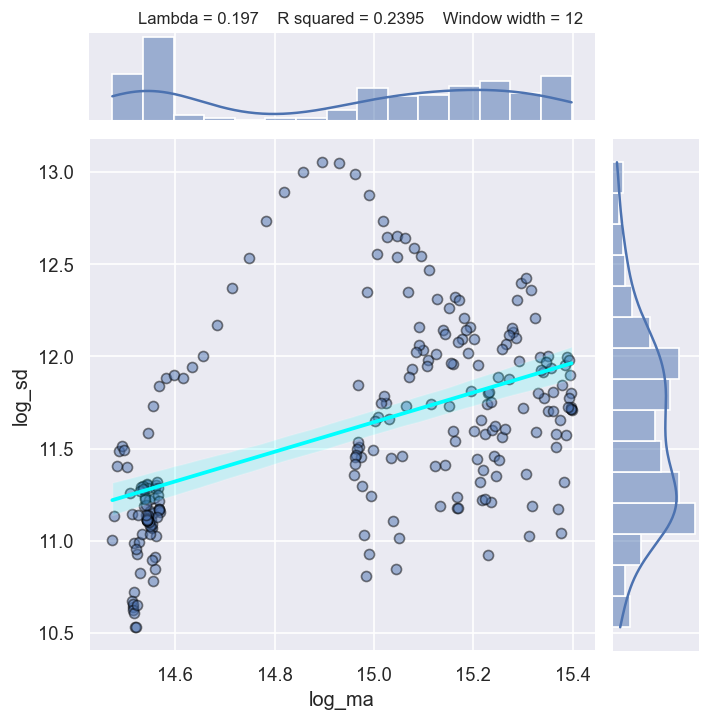

In [266]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

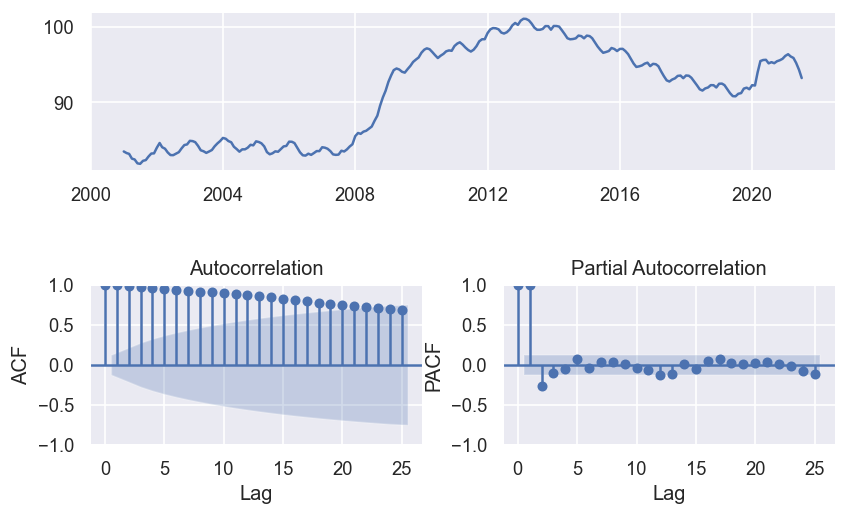

In [267]:
#!!!!!Revisar si hace falta o con lo hecho por Juan vale
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)

In [268]:

# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,2,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],trend='n')
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  247
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                  -2.947
Date:                            Tue, 28 Nov 2023   AIC                             15.895
Time:                                    19:52:37   BIC                             33.150
Sample:                                01-01-2001   HQIC                            22.853
                                     - 07-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
COVID          0.3652      0.047      7.713      0.000       0.272       0.458
ar.L1          0.4767      0.066   

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  32.923143    0.97025


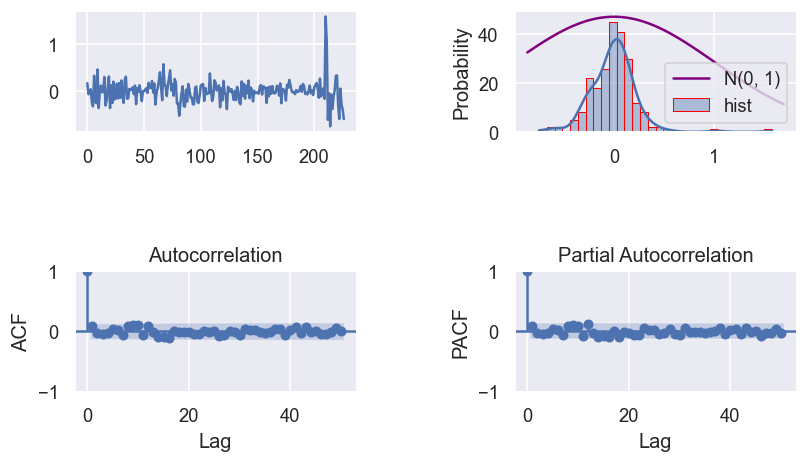

In [269]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[20:]),lags=50)
 

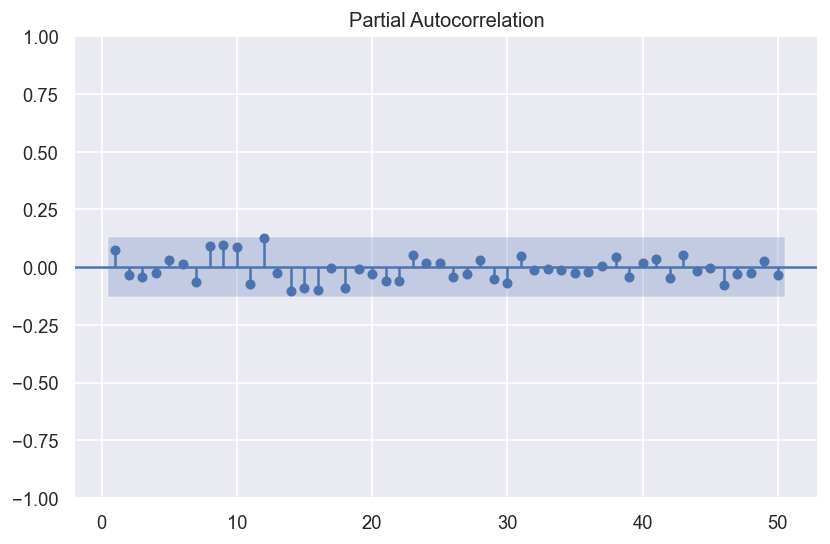

<Figure size 960x600 with 0 Axes>

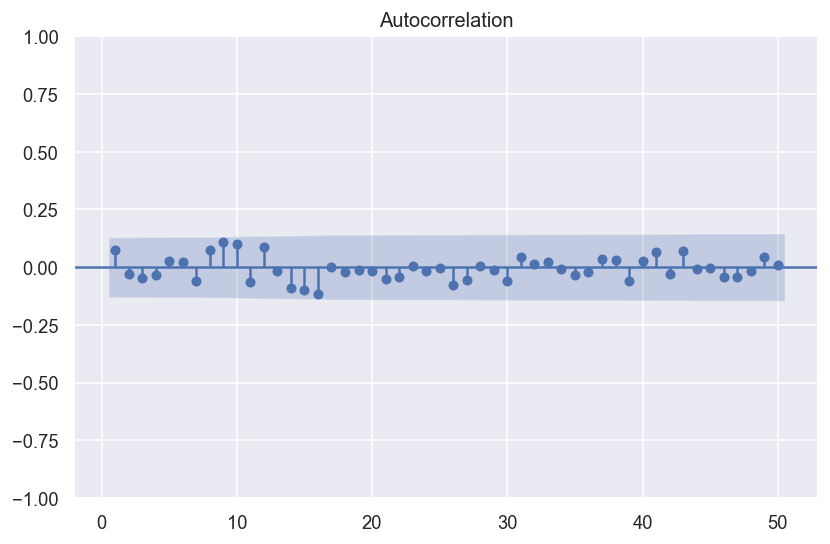

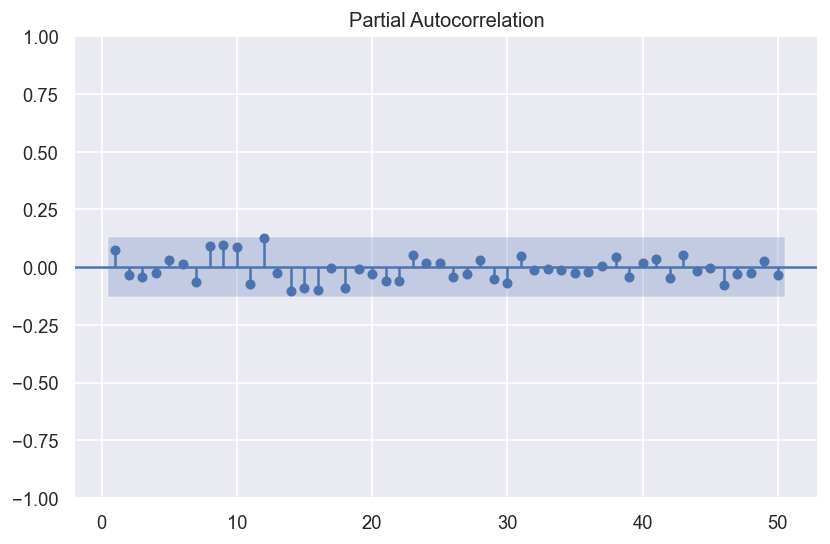

In [270]:
plt.figure()
plot_acf(res_sarimax.resid.values[20:], lags=50,zero=False)
plot_pacf(res_sarimax.resid.values[20:], lags=50,zero=False)

Se ha iniciando probando el modelo óptimo obtenido en el SARIMA(1,2,1)x(0,1,1,12) obteniendo resultados muy malos para los residuos, tras ello se han seguido probando modelos incluyendo diferenciación tanto regular como estacional en los modelos, siempre observando correlaciones parciales muy altas entre los residuos de la serie y sus retardos estacionales(E(12),E(24),E(36,...)).Cambiar los parámetros del sarimax en el código para ver este fenómeno.

Por último, se decidió eliminar la diferenciación estacional para ver si de esta manera se conseguía eliminar este efecto, y se consiguió, llegando al modelo óptimo mostrado arriba, en que prácticamenete con un 100% de confianza se afirma que los residuos del modelo son ruido blanco(Ver p-valor del test de Ljung-Box).

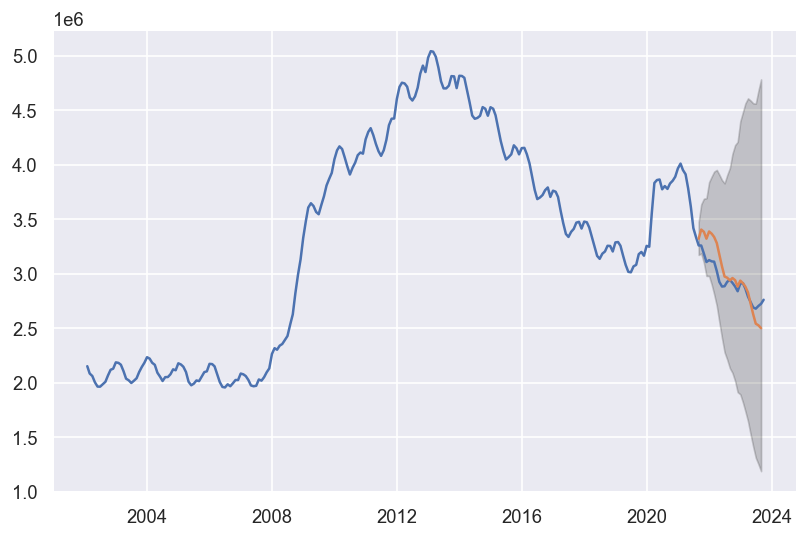

In [272]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start



pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y['2002-02-01':])
plt.plot(yhat['2002-02-01':])
plt.show()

In [216]:
df.index[247]

Timestamp('2021-08-01 00:00:00')

In [168]:
 #Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 919242.7772334847
Test RMSE SARIMA 1 d = 2: 1036634.0009528551


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p